# Проект
В работе будет использована *линейная регрессия.*

Используемый датасет: https://www.kaggle.com/datasets/harishkumardatalab/housing-price-prediction

This dataset provides comprehensive information for house price prediction, with 13 column names:

**Price**: The price of the house.

**Area**: The total area of the house in square feet.

**Bedrooms**: The number of bedrooms in the house.

**Bathrooms**: The number of bathrooms in the house.

**Stories**: The number of stories in the house.

**Mainroad**: Whether the house is connected to the main road (Yes/No).

**Guestroom**: Whether the house has a guest room (Yes/No).

**Basement**: Whether the house has a basement (Yes/No).

**Hot water heating**: Whether the house has a hot water heating system (Yes/No).

**Airconditioning**: Whether the house has an air conditioning system (Yes/No).

**Parking**: The number of parking spaces available within the house.

**Prefarea**: Whether the house is located in a preferred area (Yes/No).

**Furnishing status**: The furnishing status of the house (Fully Furnished, Semi-Furnished, Unfurnished).


# 1. Подключение датасета

In [5]:
from google.colab import files
import os

uploaded = files.upload()


Saving kaggle.json to kaggle.json


In [6]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!pip install -q kaggle

In [7]:
!kaggle datasets download -d harishkumardatalab/housing-price-prediction

Dataset URL: https://www.kaggle.com/datasets/harishkumardatalab/housing-price-prediction
License(s): CC0-1.0
  0% 0.00/4.63k [00:00<?, ?B/s]
100% 4.63k/4.63k [00:00<00:00, 2.03MB/s]


In [8]:
! unzip '/content/housing-price-prediction.zip' -d '/content/housing-price-prediction'

Archive:  /content/housing-price-prediction.zip
  inflating: /content/housing-price-prediction/Housing.csv  


# 2. Предобработка данных

In [120]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


%matplotlib inline

In [10]:
df=pd.read_csv('/content/housing-price-prediction/Housing.csv')
df.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


Получим информацию о нашем датасете

---



In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   price             545 non-null    int64 
 1   area              545 non-null    int64 
 2   bedrooms          545 non-null    int64 
 3   bathrooms         545 non-null    int64 
 4   stories           545 non-null    int64 
 5   mainroad          545 non-null    object
 6   guestroom         545 non-null    object
 7   basement          545 non-null    object
 8   hotwaterheating   545 non-null    object
 9   airconditioning   545 non-null    object
 10  parking           545 non-null    int64 
 11  prefarea          545 non-null    object
 12  furnishingstatus  545 non-null    object
dtypes: int64(6), object(7)
memory usage: 55.5+ KB



Проверим, есть ли в нашем датасете пропущенные значения (проверка на пропуски)

---




In [12]:
df.describe()

print("\nПропущенные значения:")
print(df.isnull().sum())


Пропущенные значения:
price               0
area                0
bedrooms            0
bathrooms           0
stories             0
mainroad            0
guestroom           0
basement            0
hotwaterheating     0
airconditioning     0
parking             0
prefarea            0
furnishingstatus    0
dtype: int64


Проведем проверку на дубликаты

---



In [13]:
df.duplicated().sum()

np.int64(0)

Визуализируем некоторые известные нам данные (н.п. параметры *Price* и *Area*) и узнаем, насколько часто встречаются те или иные значения

---



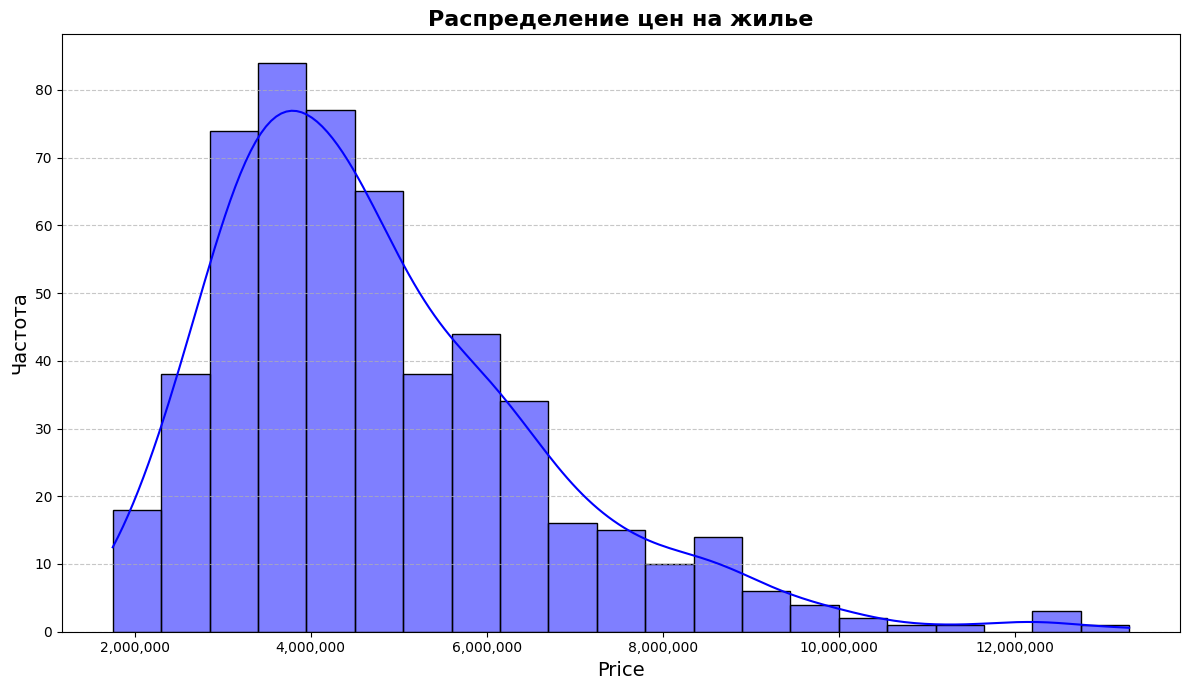

In [175]:
plt.figure(figsize=(12, 7))
sns.histplot(df['price'], kde=True, color='blue', edgecolor='black')
plt.title('Распределение цен на жилье', fontsize=16, fontweight='bold')
plt.xlabel('Price', fontsize=14)
plt.ylabel('Частота', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.ticklabel_format(style='plain', axis='x')
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, p: f'{int(x):,}'))

plt.tight_layout()
plt.show()

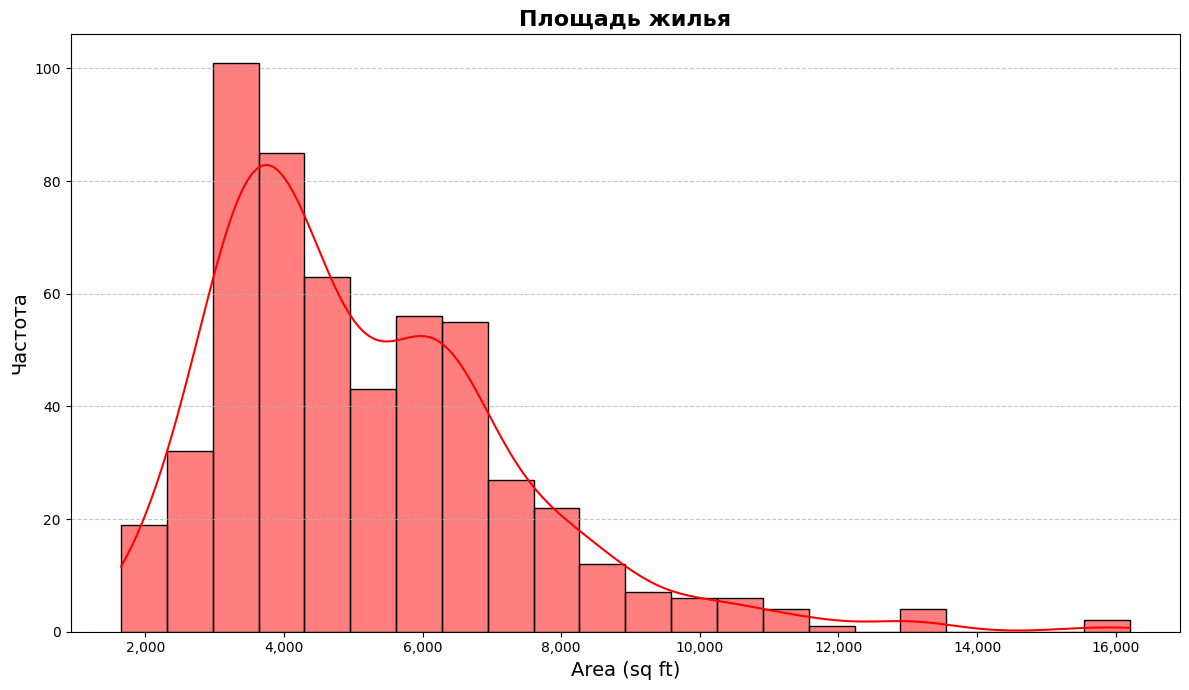

In [176]:
plt.figure(figsize=(12, 7))
sns.histplot(df['area'], kde=True, color='red', edgecolor='black')
plt.title('Площадь жилья', fontsize=16, fontweight='bold')
plt.xlabel('Area (sq ft)', fontsize=14)
plt.ylabel('Частота', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ticklabel_format(style='plain', axis='x')
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, p: f'{int(x):,}'))
plt.tight_layout()
plt.show()

Посчитаем корреляцию неприрывных признаков.

---



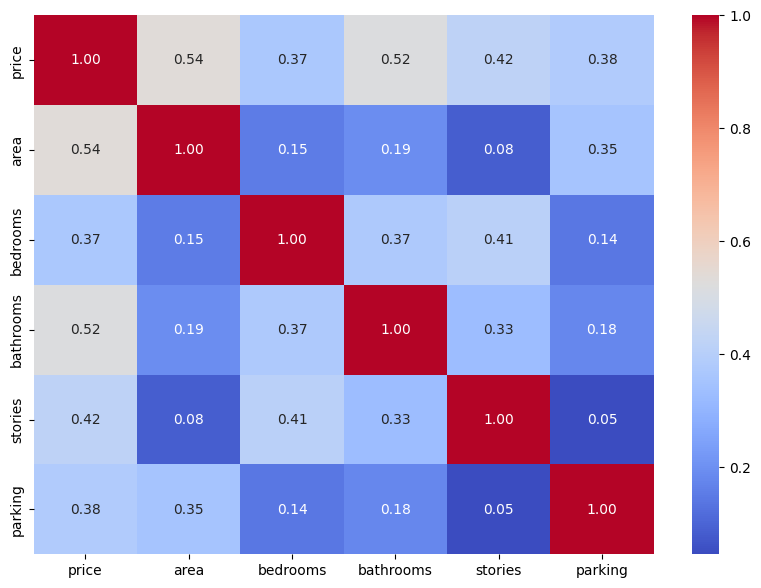

In [181]:
plt.figure(figsize=(10, 7))

sns.heatmap(df.corr(numeric_only = True), annot=True, fmt='0.2f', cmap='coolwarm');


Преобразуем категориальные признаки. Используем One-Hot Encoding

---




In [34]:
df_processed = df.copy()

# Список бинарных категориальных признаков
binary_cols = ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea']

# Преобразование бинарных признаков в числовые (0/1)
for col in binary_cols:
    df_processed[col] = df_processed[col].map({'yes': 1, 'no': 0})

# Обработка признака furnishingstatus
df_processed = pd.get_dummies(df_processed, columns=['furnishingstatus'], prefix='furnishing', drop_first= True)
bool_cols = df_processed.select_dtypes(include='bool').columns
df_processed[bool_cols] = df_processed[bool_cols].astype(int)
print("Размер датасета после обработки категориальных признаков:", df_processed.shape)
df_processed.head()


Размер датасета после обработки категориальных признаков: (545, 14)


,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishing_semi-furnished,furnishing_unfurnished
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,0,0
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,0,0
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,1,0
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,0,0
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,0,0


Определим целевую переменную *y*. В нашем случае она представляется столбцом *Price*. Все остальные столбцы - признаки.

---



In [35]:
X = df_processed.drop('price', axis=1)
y = df_processed['price']

print(f"Размер матрицы признаков: {X.shape}")
X


Размер матрицы признаков: (545, 13)


,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishing_semi-furnished,furnishing_unfurnished
0,7420,4,2,3,1,0,0,0,1,2,1,0,0
1,8960,4,4,4,1,0,0,0,1,3,0,0,0
2,9960,3,2,2,1,0,1,0,0,2,1,1,0
3,7500,4,2,2,1,0,1,0,1,3,1,0,0
4,7420,4,1,2,1,1,1,0,1,2,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
540,3000,2,1,1,1,0,1,0,0,2,0,0,1
541,2400,3,1,1,0,0,0,0,0,0,0,1,0
542,3620,2,1,1,1,0,0,0,0,0,0,0,1
543,2910,3,1,1,0,0,0,0,0,0,0,0,0


In [36]:
print(f"Размер целевой переменной: {y.shape}")
y

Размер целевой переменной: (545,)


,price
0,13300000
1,12250000
2,12250000
3,12215000
4,11410000
...,...
540,1820000
541,1767150
542,1750000
543,1750000


# 3. Определение тренировочной, валидационной и тестовой выборок


In [154]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, random_state=42
)

print(f"Размер обучающей выборки: {X_train.shape}")
print(f"Размер валидационной выборки: {X_val.shape}")
print(f"Размер тестовой выборки: {X_test.shape}")

Размер обучающей выборки: (327, 13)
Размер валидационной выборки: (109, 13)
Размер тестовой выборки: (109, 13)


Приступаем к предобработке выборок. Для этого сначала проведем процедуру нормализации ( *MinMaxScaler()* ), затем - стандартизации ( *StandardScaler()* )

---



In [178]:
numeric_features = ['area', 'bedrooms', 'bathrooms', 'stories', 'parking']
print(f"\nЧисловые признаки для масштабирования: {numeric_features}")


Числовые признаки для масштабирования: ['area', 'bedrooms', 'bathrooms', 'stories', 'parking']


In [177]:
minmax_scaler = MinMaxScaler()
minmax_scaler.fit(X_train[numeric_features])

X_train_minmax = X_train.copy()
X_val_minmax = X_val.copy()
X_test_minmax = X_test.copy()

X_train_minmax[numeric_features] = minmax_scaler.transform(X_train[numeric_features])
X_val_minmax[numeric_features] = minmax_scaler.transform(X_val[numeric_features])
X_test_minmax[numeric_features] = minmax_scaler.transform(X_test[numeric_features])

X_train_minmax



,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishing_semi-furnished,furnishing_unfurnished
231,0.183505,0.4,0.000000,0.000000,1,0,0,0,0,0.000000,1,1,0
27,0.496564,0.4,0.000000,0.000000,1,0,0,0,0,0.333333,0,1,0
412,0.065979,0.4,0.000000,0.333333,1,0,1,0,0,0.000000,1,0,1
393,0.396838,0.4,0.000000,0.000000,0,0,0,0,0,0.000000,0,0,1
59,0.298969,0.4,0.333333,1.000000,1,1,0,0,1,0.333333,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
261,0.127835,0.4,0.000000,0.333333,1,0,0,0,0,0.000000,0,1,0
108,0.109278,0.6,0.000000,0.666667,1,0,0,0,0,0.333333,0,1,0
142,0.608247,0.6,0.333333,0.333333,1,0,0,0,0,0.333333,0,1,0
513,0.189003,0.4,0.000000,0.333333,1,0,0,0,0,0.000000,0,0,1


In [156]:
standard_scaler = StandardScaler()
standard_scaler.fit(X_train_minmax[numeric_features])

X_train_final = X_train_minmax.copy()
X_val_final = X_val_minmax.copy()
X_test_final = X_test_minmax.copy()

X_train_final[numeric_features] = standard_scaler.transform(X_train_minmax[numeric_features])
X_val_final[numeric_features] = standard_scaler.transform(X_val_minmax[numeric_features])
X_test_final[numeric_features] = standard_scaler.transform(X_test_minmax[numeric_features])

X_train_final


,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishing_semi-furnished,furnishing_unfurnished
231,-0.392432,0.027875,-0.563773,-0.941553,1,0,0,0,0,-0.798983,1,1,0
27,1.684411,0.027875,-0.563773,-0.941553,1,0,0,0,0,0.346927,0,1,0
412,-1.172102,0.027875,-0.563773,0.220288,1,0,1,0,0,-0.798983,1,0,1
393,1.022830,0.027875,-0.563773,-0.941553,0,0,0,0,0,-0.798983,0,0,1
59,0.373561,0.027875,1.462092,2.543970,1,1,0,0,1,0.346927,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
261,-0.761749,0.027875,-0.563773,0.220288,1,0,0,0,0,-0.798983,0,1,0
108,-0.884855,1.330034,-0.563773,1.382129,1,0,0,0,0,0.346927,0,1,0
142,2.425326,1.330034,1.462092,0.220288,1,0,0,0,0,0.346927,0,1,0
513,-0.355956,0.027875,-0.563773,0.220288,1,0,0,0,0,-0.798983,0,0,1


# 4. Создание модели

In [147]:
model = LinearRegression()

model.fit(X_train_final, y_train)

LinearRegression()

Предсказания на валидационной выборке

---



In [150]:
y_val_pred = model.predict(X_val_final)

# Метрики
mse_val = mean_squared_error(y_val, y_val_pred)
mae_val = mean_absolute_error(y_val, y_val_pred)
r2_val = r2_score(y_val, y_val_pred)

print("Результаты на валидационной выборке:")
print(f"Mean Squared Error (MSE): {mse_val:.2f}")
print(f"Root Mean Squared Error (RMSE): {np.sqrt(mse_val):.2f}")
print(f"Mean Absolute Error (MAE): {mae_val:.2f}")
print(f"R² Score: {r2_val:.4f}")

Результаты на валидационной выборке:
Mean Squared Error (MSE): 991588448075.91
Root Mean Squared Error (RMSE): 995785.34
Mean Absolute Error (MAE): 738802.56
R² Score: 0.6632


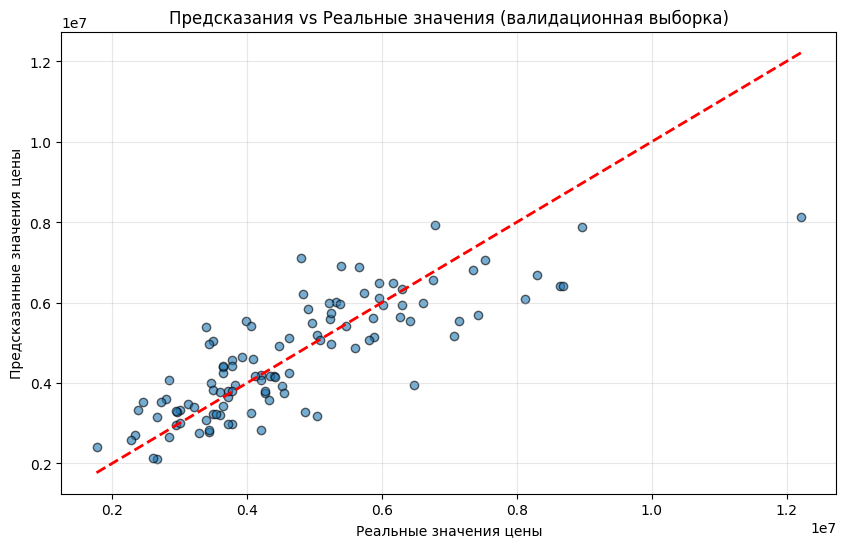

In [157]:
plt.figure(figsize=(10, 6))
plt.scatter(y_val, y_val_pred, alpha=0.6, edgecolors='black')
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
plt.xlabel('Реальные значения цены')
plt.ylabel('Предсказанные значения цены')
plt.title('Предсказания vs Реальные значения (валидационная выборка)')
plt.grid(True, alpha=0.3)
plt.show()



 Предсказания на тестовой выборке

---



In [159]:
y_test_pred = model.predict(X_test_final)

# Метрики качества
mse_test = mean_squared_error(y_test, y_test_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)

print("Результаты на тестовой выборке:")
print(f"Mean Squared Error (MSE): {mse_test:.2f}")
print(f"Root Mean Squared Error (RMSE): {np.sqrt(mse_test):.2f}")
print(f"Mean Absolute Error (MAE): {mae_test:.2f}")
print(f"R² Score: {r2_test:.4f}")

# Сравнение с валидационной выборкой
print("\nСравнение метрик:")
print(f"MSE: валидация = {mse_val:.2f}; тест = {mse_test:.2f}")
print(f"R²: валидация = {r2_val:.4f}; тест = {r2_test:.4f}")

Результаты на тестовой выборке:
Mean Squared Error (MSE): 1750751667551.37
Root Mean Squared Error (RMSE): 1323159.73
Mean Absolute Error (MAE): 963036.30
R² Score: 0.6536

Сравнение метрик:
MSE: валидация = 991588448075.91; тест = 1750751667551.37
R²: валидация = 0.6632; тест = 0.6536


Создаем DataFrame для анализа предсказаний

---



In [169]:
results_df = pd.DataFrame({
    'Реальная цена': y_test.values,
    'Предсказанная цена': y_test_pred,
    'Ошибка': y_test.values - y_test_pred,
    'Относительная ошибка (%)': np.abs((y_test.values - y_test_pred) / y_test.values) * 100
})

# Примеры предсказаний
print("\nПримеры предсказаний (первые 10 записей):")
print(results_df.head(10))


Примеры предсказаний (первые 10 записей):
   Реальная цена  Предсказанная цена        Ошибка  Относительная ошибка (%)
0        4060000        5.158472e+06 -1.098472e+06                 27.055970
1        6650000        7.238559e+06 -5.885589e+05                  8.850510
2        3710000        3.082431e+06  6.275689e+05                 16.915602
3        6440000        4.565260e+06  1.874740e+06                 29.110868
4        2800000        3.248557e+06 -4.485574e+05                 16.019908
5        4900000        3.533759e+06  1.366241e+06                 27.882468
6        5250000        5.473290e+06 -2.232901e+05                  4.253145
7        4543000        6.386961e+06 -1.843961e+06                 40.589051
8        2450000        2.615064e+06 -1.650643e+05                  6.737320
9        3353000        2.570439e+06  7.825613e+05                 23.339137


Сохраняем нашу модель

---



In [184]:
import joblib
import json

joblib.dump(model, 'linear_regression_model.pkl')
joblib.dump(scaler, 'scaler.pkl')

from google.colab import files
files.download('linear_regression_model.pkl')
files.download('scaler.pkl')

print("Модель и результаты успешно сохранены:")
print("- linear_regression_model.pkl")
print("- scaler.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Модель и результаты успешно сохранены:
- linear_regression_model.pkl
- scaler.pkl
